In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [7]:
# Configure API key

quandl.ApiConfig.api_key = '9ptqy97VtvaVSzcZ92W_'

In [8]:
# Federal Reserve Economic Data - Natural Rate of Unemployment

data = quandl.get('FRED/NROU')

In [9]:
data.head(5)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [10]:
data.shape

(332, 1)

In [11]:
data.columns

Index(['Value'], dtype='object')

In [12]:
type(data)

pandas.core.frame.DataFrame

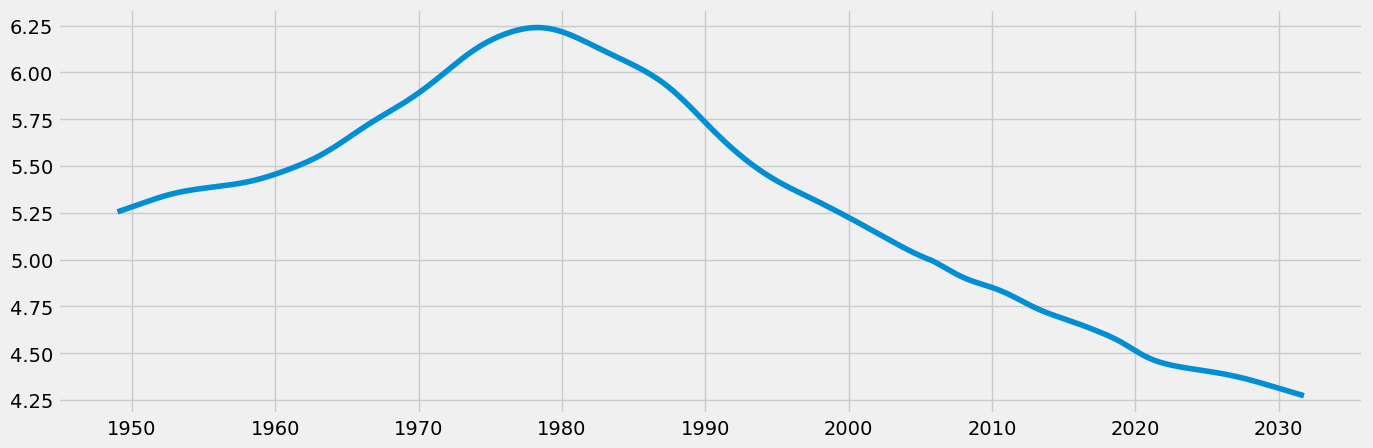

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

2. Subsetting, wrangling & cleaning time-series data

In [14]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [15]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [16]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [17]:
data_sub.shape

(162, 2)

In [18]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [19]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


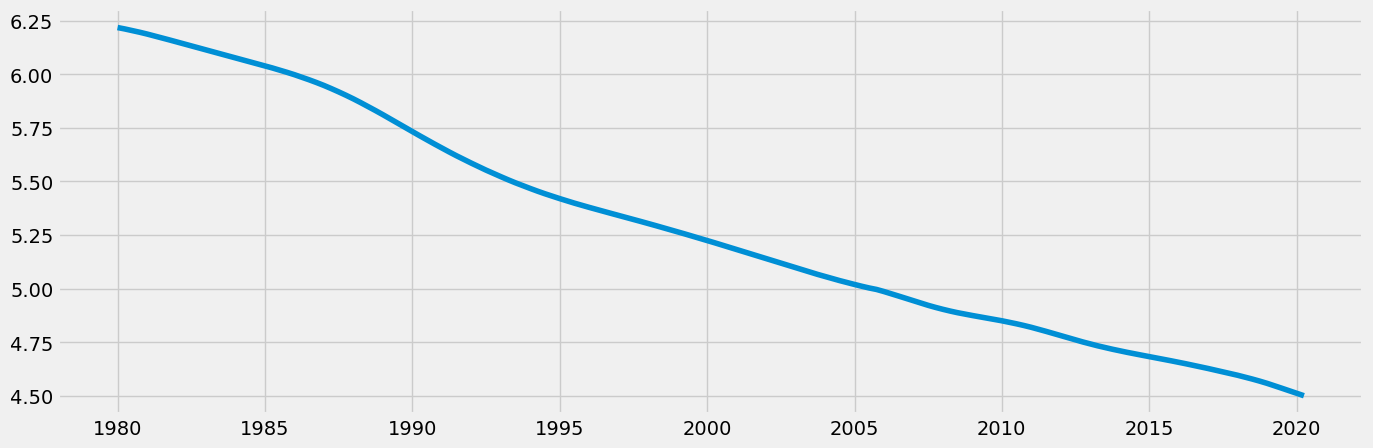

In [20]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [21]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum()

Value    0
dtype: int64

In [22]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

3. Time-Series analysis: decomposition 

In [23]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [24]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

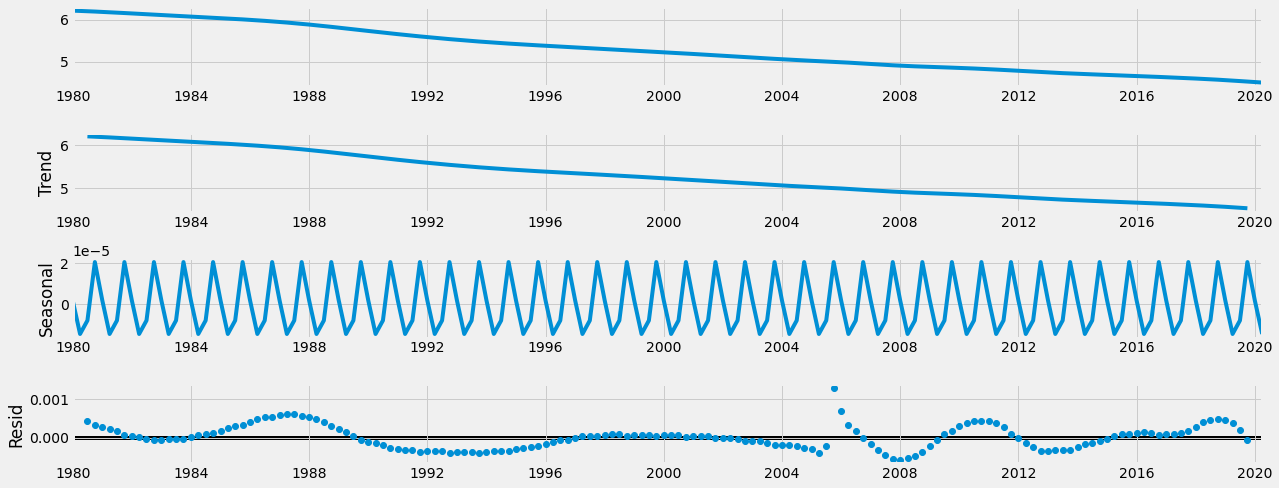

In [25]:
# Plot the separate components

decomposition.plot()
plt.show()

4. Testing for Stationarity 

In [26]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


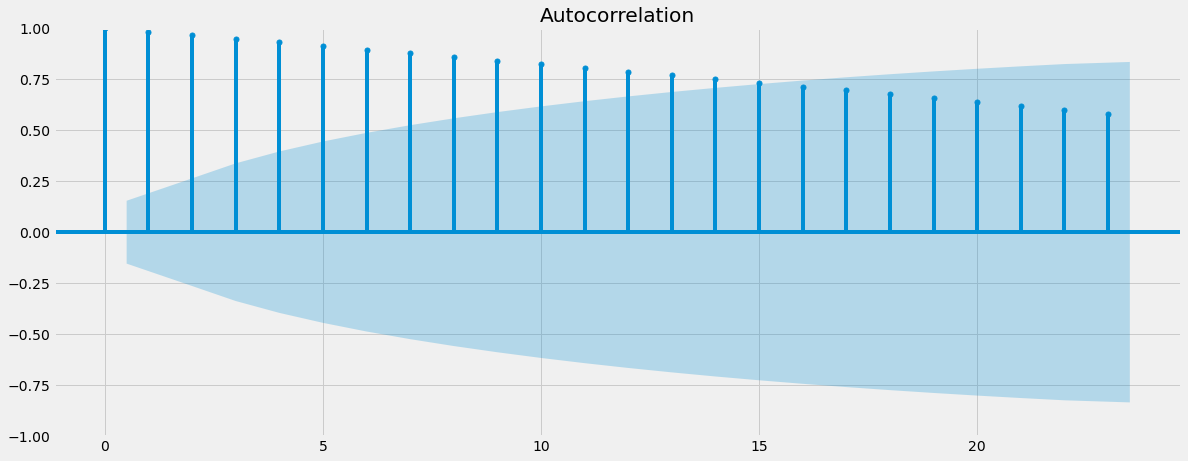

In [27]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

5. Stationarizing the Federal Reserve Economic Data

In [28]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [29]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [30]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [31]:
data_diff.columns

Index(['Value'], dtype='object')

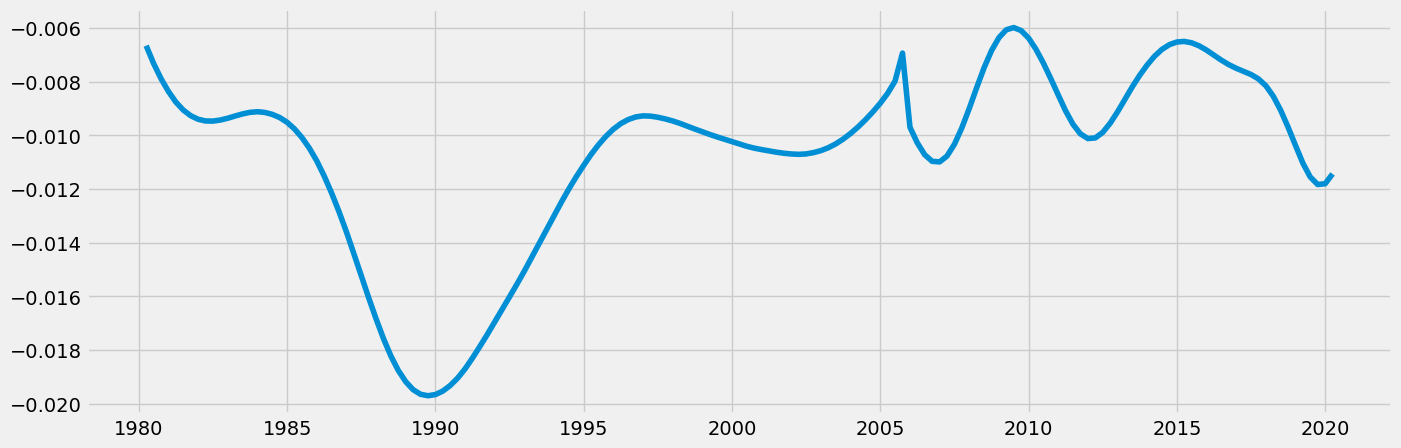

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


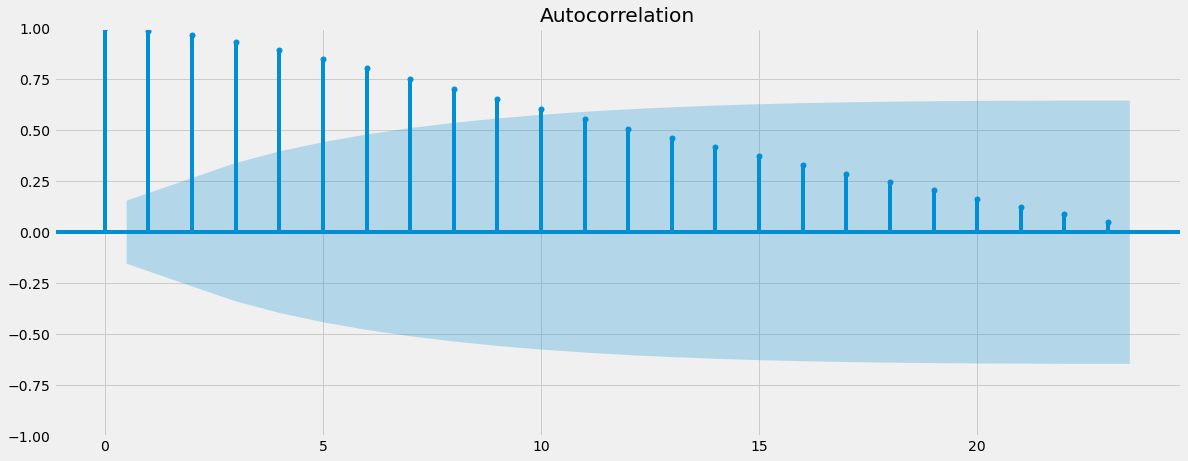

In [34]:
plot_acf(data_diff)
plt.show()